In [1]:
import os
import cv2
import json
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# ==============================================================
# CONFIG
# ==============================================================

CONFIG = {
    "data_dir": "/kaggle/input/full-data-fall/Preprocessed_Videos",
    "save_dir": "/kaggle/working",

    "sequence_length": 8,
    "resize": (96, 96),

    "batch_size": 16,
    "num_epochs": 30,
    "learning_rate": 5e-4,  # Reduced learning rate
    "weight_decay": 1e-3,   # Stronger L2 regularization

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 2,
    "pin_memory": True,
    
    # Early stopping
    "early_stopping_patience": 8,
}


# ==============================================================
# DATASET WITH AUGMENTATION
# ==============================================================

class SimpleFlowDataset(Dataset):
    def __init__(self, data_dir, seq_len=8, resize=(96, 96), augment=False):
        self.seq_len = seq_len
        self.resize = resize
        self.augment = augment
        self.samples = []

        for label_name, label in [("fall", 0), ("no_fall", 1)]:
            folder = os.path.join(data_dir, label_name, "optical_flow")
            if not os.path.exists(folder): 
                continue

            for f in os.listdir(folder):
                if f.endswith("_flow.npy"):
                    self.samples.append((os.path.join(folder, f), label))

        print("Total samples:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        flow = np.load(path)  # (T, H, W, 2)

        # Resize all frames
        frames = [cv2.resize(f, self.resize) for f in flow]

        # Sample frames uniformly
        idx = np.linspace(0, len(frames)-1, self.seq_len).astype(int)
        
        # Temporal jitter during training
        if self.augment:
            jitter = np.random.randint(-2, 3, size=self.seq_len)
            idx = np.clip(idx + jitter, 0, len(frames)-1)
        
        frames = np.array(frames)[idx]  # (seq, H, W, 2)

        # Spatial augmentation
        if self.augment:
            # Horizontal flip (50% chance)
            if np.random.rand() > 0.5:
                frames = np.flip(frames, axis=2).copy()
                frames[..., 0] *= -1  # Invert horizontal flow component
            
            # Random rotation (-10 to +10 degrees)
            if np.random.rand() > 0.5:
                angle = np.random.uniform(-10, 10)
                frames = self._rotate_frames(frames, angle)
            
            # Gaussian noise
            if np.random.rand() > 0.5:
                noise = np.random.normal(0, 0.03, frames.shape)
                frames = frames + noise
            
            # Random brightness
            if np.random.rand() > 0.5:
                brightness = np.random.uniform(0.8, 1.2)
                frames = frames * brightness
            
            frames = np.clip(frames, -10, 10)

        # Convert to tensor (T, C, H, W)
        x = torch.tensor(frames).permute(0, 3, 1, 2).float()
        y = torch.tensor(label).long()
        return x, y
    
    def _rotate_frames(self, frames, angle):
        """Rotate frames and adjust flow vectors"""
        h, w = frames.shape[1], frames.shape[2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        rotated = []
        for frame in frames:
            # Rotate frame
            frame_rotated = cv2.warpAffine(frame, M, (w, h))
            rotated.append(frame_rotated)
        
        return np.array(rotated)


# ==============================================================
# IMPROVED 3D CNN WITH STRONGER REGULARIZATION
# ==============================================================

class CNN3D_Flow(nn.Module):
    def __init__(self, dropout_rate=0.6):  # Increased dropout
        super().__init__()

        self.features = nn.Sequential(
            # Conv3D 1
            nn.Conv3d(2, 32, kernel_size=(3, 5, 5), padding=(1, 2, 2)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout3d(0.2),  # Added dropout in conv layers
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            # Conv3D 2
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Dropout3d(0.3),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),

            # Conv3D 3
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Dropout3d(0.4),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
        )

        # Simplified classifier with strong regularization
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 12 * 12, 256),  # Reduced from 512
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        # x: (B, T, 2, H, W) → convert to (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


# ==============================================================
# TRAIN + VALIDATION
# ==============================================================

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item()
        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()

    acc = 100 * correct / total
    return total_loss / len(loader), acc


def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Validation", leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            _, pred = out.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = 100 * correct / total
    return total_loss / len(loader), acc, all_preds, all_labels


# ==============================================================
# MAIN TRAINING SCRIPT
# ==============================================================

def main():
    device = CONFIG["device"]
    print("="*60)
    print("FALL DETECTION - ANTI-OVERFITTING TRAINING")
    print("="*60)
    print(f"Device: {device}")
    print(f"Learning Rate: {CONFIG['learning_rate']}")
    print(f"Weight Decay: {CONFIG['weight_decay']}")
    print(f"Early Stopping Patience: {CONFIG['early_stopping_patience']}")
    print("="*60 + "\n")

    # Create datasets with augmentation
    train_dataset = SimpleFlowDataset(
        CONFIG["data_dir"],
        seq_len=CONFIG["sequence_length"],
        resize=CONFIG["resize"],
        augment=True  # Enable augmentation for training
    )
    
    val_dataset = SimpleFlowDataset(
        CONFIG["data_dir"],
        seq_len=CONFIG["sequence_length"],
        resize=CONFIG["resize"],
        augment=False  # No augmentation for validation
    )

    # Split dataset with fixed seed
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    
    generator = torch.Generator().manual_seed(42)
    train_indices = torch.randperm(len(train_dataset), generator=generator)[:train_size].tolist()
    val_indices = torch.randperm(len(train_dataset), generator=generator)[train_size:].tolist()
    
    train_set = torch.utils.data.Subset(train_dataset, train_indices)
    val_set = torch.utils.data.Subset(val_dataset, val_indices)

    print(f"Training samples: {len(train_set)}")
    print(f"Validation samples: {len(val_set)}\n")

    train_loader = DataLoader(
        train_set, batch_size=CONFIG["batch_size"],
        shuffle=True, num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"]
    )

    val_loader = DataLoader(
        val_set, batch_size=CONFIG["batch_size"],
        shuffle=False, num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"]
    )

    model = CNN3D_Flow(dropout_rate=0.6).to(device)
    print("Model parameters:", sum(p.numel() for p in model.parameters()))

    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"]
    )
    
    # Cosine annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=CONFIG["num_epochs"],
        eta_min=1e-6
    )
    
    criterion = nn.CrossEntropyLoss()

    history = {
        "train_loss": [], "train_acc": [], 
        "val_loss": [], "val_acc": [],
        "learning_rates": []
    }
    
    best_acc = 0
    best_epoch = 0
    patience_counter = 0
    
    # Store best predictions for confusion matrix
    best_preds = None
    best_labels = None

    print("Starting training...\n")

    for epoch in range(1, CONFIG["num_epochs"] + 1):
        print(f"{'='*60}")
        print(f"EPOCH {epoch}/{CONFIG['num_epochs']}")
        print(f"{'='*60}")
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.6f}")

        # Train and validate
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        vl_loss, vl_acc, preds, labels = validate(model, val_loader, criterion, device)

        print(f"Train: Loss={tr_loss:.4f} | Acc={tr_acc:.2f}%")
        print(f"Val:   Loss={vl_loss:.4f} | Acc={vl_acc:.2f}%")
        
        gap = tr_acc - vl_acc
        print(f"Overfitting Gap: {gap:.2f}%")

        # Update scheduler
        scheduler.step()

        # Save history
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(vl_acc)
        history["learning_rates"].append(current_lr)

        # Save best model
        if vl_acc > best_acc:
            best_acc = vl_acc
            best_epoch = epoch
            patience_counter = 0
            best_preds = preds
            best_labels = labels
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'predictions': preds,
                'labels': labels
            }, os.path.join(CONFIG["save_dir"], "best_model.pth"))
            print(f"✓ NEW BEST MODEL! Val Acc: {best_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")

        # Early stopping
        if patience_counter >= CONFIG["early_stopping_patience"]:
            print(f"\n{'='*60}")
            print(f"Early stopping at epoch {epoch}")
            print(f"Best Val Acc: {best_acc:.2f}% at epoch {best_epoch}")
            print(f"{'='*60}")
            break

        print()

    # Save history and best predictions
    history['best_predictions'] = best_preds
    history['best_labels'] = best_labels
    history['best_epoch'] = best_epoch
    history['best_acc'] = best_acc
    
    with open(os.path.join(CONFIG["save_dir"], "history.json"), "w") as f:
        json.dump({k: v for k, v in history.items() if k not in ['best_predictions', 'best_labels']}, f, indent=2)
    
    # Save predictions separately
    np.savez(os.path.join(CONFIG["save_dir"], "predictions.npz"),
             predictions=best_preds,
             labels=best_labels)

    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)
    print(f"Best validation accuracy: {best_acc:.2f}% (epoch {best_epoch})")
    print(f"Final overfitting gap: {history['train_acc'][best_epoch-1] - best_acc:.2f}%")
    print("="*60)


if __name__ == "__main__":
    main()

FALL DETECTION - ANTI-OVERFITTING TRAINING
Device: cuda
Learning Rate: 0.0005
Weight Decay: 0.001
Early Stopping Patience: 8

Total samples: 4600
Total samples: 4600
Training samples: 3680
Validation samples: 920

Model parameters: 9720418
Starting training...

EPOCH 1/30
Learning Rate: 0.000500


Train: Loss=0.5169 | Acc=77.23%
Val:   Loss=0.4033 | Acc=83.26%
Overfitting Gap: -6.03%
✓ NEW BEST MODEL! Val Acc: 83.26%

EPOCH 2/30
Learning Rate: 0.000499


Train: Loss=0.4536 | Acc=80.62%
Val:   Loss=0.3486 | Acc=86.41%
Overfitting Gap: -5.79%
✓ NEW BEST MODEL! Val Acc: 86.41%

EPOCH 3/30
Learning Rate: 0.000495


Train: Loss=0.4163 | Acc=82.12%
Val:   Loss=0.3531 | Acc=85.65%
Overfitting Gap: -3.53%
No improvement. Patience: 1/8

EPOCH 4/30
Learning Rate: 0.000488


Train: Loss=0.4062 | Acc=82.12%
Val:   Loss=0.3135 | Acc=87.72%
Overfitting Gap: -5.60%
✓ NEW BEST MODEL! Val Acc: 87.72%

EPOCH 5/30
Learning Rate: 0.000478


Train: Loss=0.3912 | Acc=83.80%
Val:   Loss=0.3213 | Acc=87.28%
Overfitting Gap: -3.48%
No improvement. Patience: 1/8

EPOCH 6/30
Learning Rate: 0.000467


Train: Loss=0.3745 | Acc=84.21%
Val:   Loss=0.2935 | Acc=89.13%
Overfitting Gap: -4.92%
✓ NEW BEST MODEL! Val Acc: 89.13%

EPOCH 7/30
Learning Rate: 0.000452


Train: Loss=0.3748 | Acc=84.59%
Val:   Loss=0.3111 | Acc=87.72%
Overfitting Gap: -3.12%
No improvement. Patience: 1/8

EPOCH 8/30
Learning Rate: 0.000436


Train: Loss=0.3566 | Acc=84.84%
Val:   Loss=0.2722 | Acc=89.35%
Overfitting Gap: -4.51%
✓ NEW BEST MODEL! Val Acc: 89.35%

EPOCH 9/30
Learning Rate: 0.000417


Train: Loss=0.3526 | Acc=85.19%
Val:   Loss=0.2842 | Acc=89.35%
Overfitting Gap: -4.16%
No improvement. Patience: 1/8

EPOCH 10/30
Learning Rate: 0.000397


Train: Loss=0.3454 | Acc=86.14%
Val:   Loss=0.2630 | Acc=89.35%
Overfitting Gap: -3.21%
No improvement. Patience: 2/8

EPOCH 11/30
Learning Rate: 0.000375


Train: Loss=0.3444 | Acc=86.09%
Val:   Loss=0.2468 | Acc=90.43%
Overfitting Gap: -4.35%
✓ NEW BEST MODEL! Val Acc: 90.43%

EPOCH 12/30
Learning Rate: 0.000352


Train: Loss=0.3414 | Acc=86.90%
Val:   Loss=0.2409 | Acc=90.43%
Overfitting Gap: -3.53%
No improvement. Patience: 1/8

EPOCH 13/30
Learning Rate: 0.000328


Train: Loss=0.3308 | Acc=86.77%
Val:   Loss=0.3034 | Acc=88.91%
Overfitting Gap: -2.15%
No improvement. Patience: 2/8

EPOCH 14/30
Learning Rate: 0.000302


Train: Loss=0.3240 | Acc=87.42%
Val:   Loss=0.2273 | Acc=90.65%
Overfitting Gap: -3.23%
No improvement. Patience: 1/8

EPOCH 16/30
Learning Rate: 0.000251


Train: Loss=0.3166 | Acc=87.77%
Val:   Loss=0.2279 | Acc=91.30%
Overfitting Gap: -3.53%
✓ NEW BEST MODEL! Val Acc: 91.30%

EPOCH 17/30
Learning Rate: 0.000224


Train: Loss=0.3063 | Acc=87.72%
Val:   Loss=0.2211 | Acc=91.20%
Overfitting Gap: -3.48%
No improvement. Patience: 1/8

EPOCH 18/30
Learning Rate: 0.000199


Train: Loss=0.3060 | Acc=88.07%
Val:   Loss=0.2167 | Acc=91.20%
Overfitting Gap: -3.12%
No improvement. Patience: 2/8

EPOCH 19/30
Learning Rate: 0.000173


Train: Loss=0.2969 | Acc=88.48%
Val:   Loss=0.2352 | Acc=91.41%
Overfitting Gap: -2.93%
✓ NEW BEST MODEL! Val Acc: 91.41%

EPOCH 20/30
Learning Rate: 0.000149


Train: Loss=0.3068 | Acc=87.72%
Val:   Loss=0.2446 | Acc=91.96%
Overfitting Gap: -4.24%
✓ NEW BEST MODEL! Val Acc: 91.96%

EPOCH 21/30
Learning Rate: 0.000126


Train: Loss=0.2879 | Acc=88.26%
Val:   Loss=0.2381 | Acc=91.96%
Overfitting Gap: -3.70%
No improvement. Patience: 1/8

EPOCH 22/30
Learning Rate: 0.000104


Train: Loss=0.2890 | Acc=88.80%
Val:   Loss=0.2120 | Acc=92.61%
Overfitting Gap: -3.80%
✓ NEW BEST MODEL! Val Acc: 92.61%

EPOCH 23/30
Learning Rate: 0.000084


Train: Loss=0.2786 | Acc=89.10%
Val:   Loss=0.2137 | Acc=92.17%
Overfitting Gap: -3.07%
No improvement. Patience: 1/8

EPOCH 24/30
Learning Rate: 0.000065


Train: Loss=0.2824 | Acc=88.75%
Val:   Loss=0.2241 | Acc=91.96%
Overfitting Gap: -3.21%
No improvement. Patience: 2/8

EPOCH 25/30
Learning Rate: 0.000049


Train: Loss=0.2749 | Acc=89.27%
Val:   Loss=0.2268 | Acc=92.50%
Overfitting Gap: -3.23%
No improvement. Patience: 3/8

EPOCH 26/30
Learning Rate: 0.000034


Train: Loss=0.2680 | Acc=89.32%
Val:   Loss=0.2237 | Acc=92.28%
Overfitting Gap: -2.96%
No improvement. Patience: 4/8

EPOCH 27/30
Learning Rate: 0.000023


Train: Loss=0.2773 | Acc=88.61%
Val:   Loss=0.2095 | Acc=92.28%
Overfitting Gap: -3.67%
No improvement. Patience: 5/8

EPOCH 28/30
Learning Rate: 0.000013


Train: Loss=0.2867 | Acc=88.59%
Val:   Loss=0.2147 | Acc=92.83%
Overfitting Gap: -4.24%
✓ NEW BEST MODEL! Val Acc: 92.83%

EPOCH 29/30
Learning Rate: 0.000006


Train: Loss=0.2815 | Acc=88.21%
Val:   Loss=0.2125 | Acc=92.39%
Overfitting Gap: -4.18%
No improvement. Patience: 1/8

EPOCH 30/30
Learning Rate: 0.000002


Train: Loss=0.2735 | Acc=89.86%
Val:   Loss=0.2167 | Acc=93.04%
Overfitting Gap: -3.18%
✓ NEW BEST MODEL! Val Acc: 93.04%


TRAINING COMPLETE!
Best validation accuracy: 93.04% (epoch 30)
Final overfitting gap: -3.18%


Loading training history and predictions...
✓ Loaded 30 epochs
✓ Loaded 920 predictions



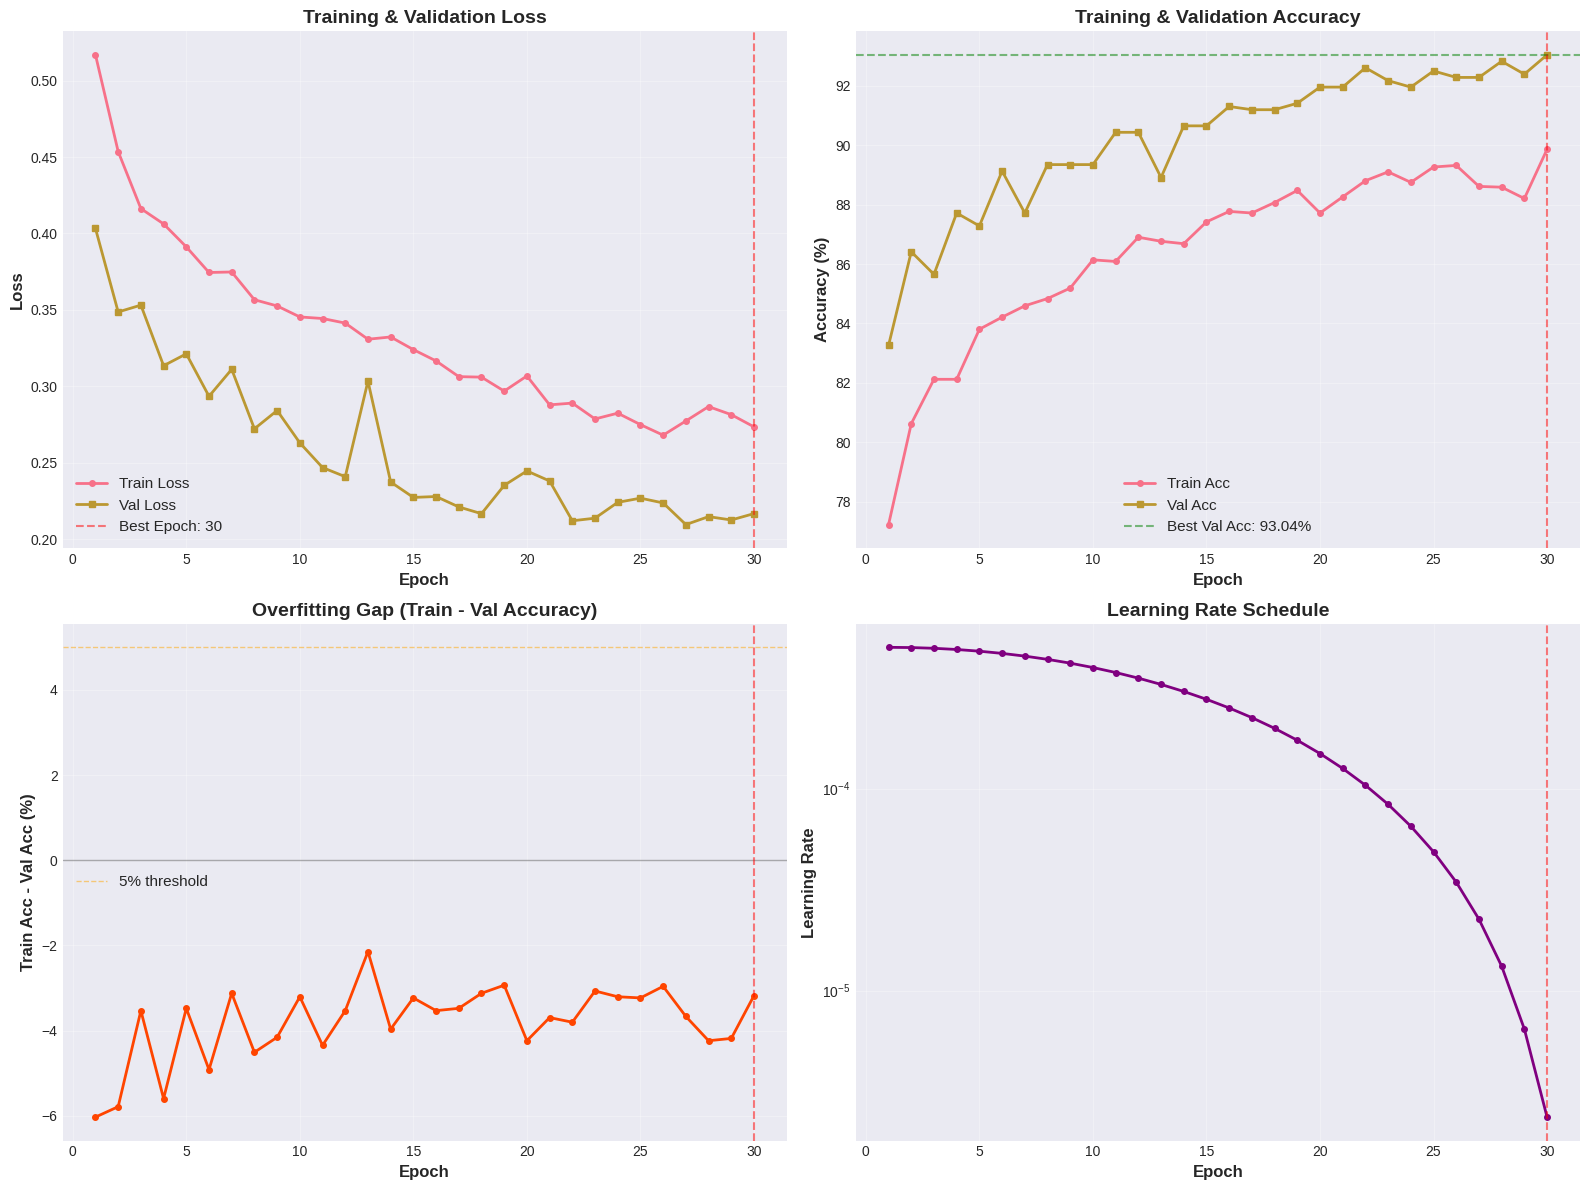

✓ Saved: training_curves.png



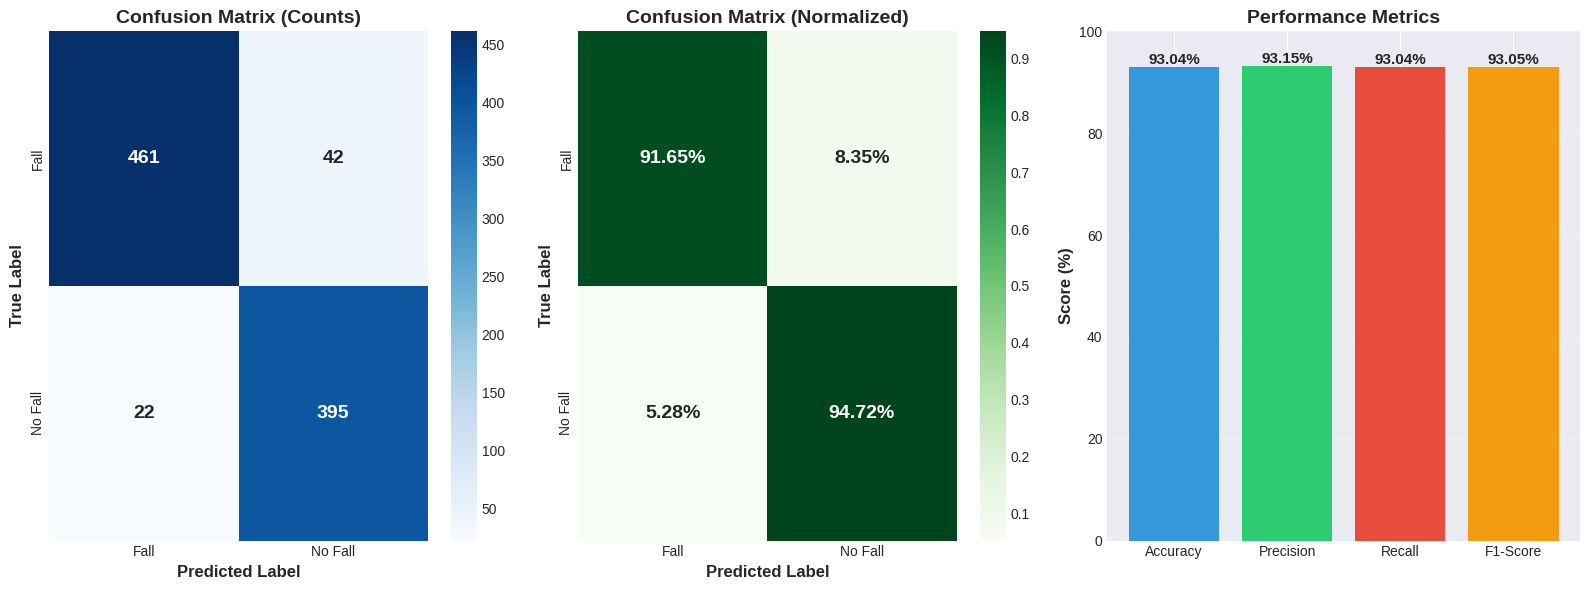

✓ Saved: confusion_matrix_metrics.png

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Fall     0.9545    0.9165    0.9351       503
     No Fall     0.9039    0.9472    0.9251       417

    accuracy                         0.9304       920
   macro avg     0.9292    0.9319    0.9301       920
weighted avg     0.9315    0.9304    0.9305       920


PER-CLASS DETAILED METRICS:
Fall Detection:
  True Positives:  395
  False Negatives: 22
  Sensitivity (Recall): 94.72%
  Precision: 90.39%

No Fall Detection:
  True Negatives:  461
  False Positives: 42
  Specificity: 91.65%
  Precision: 95.45%


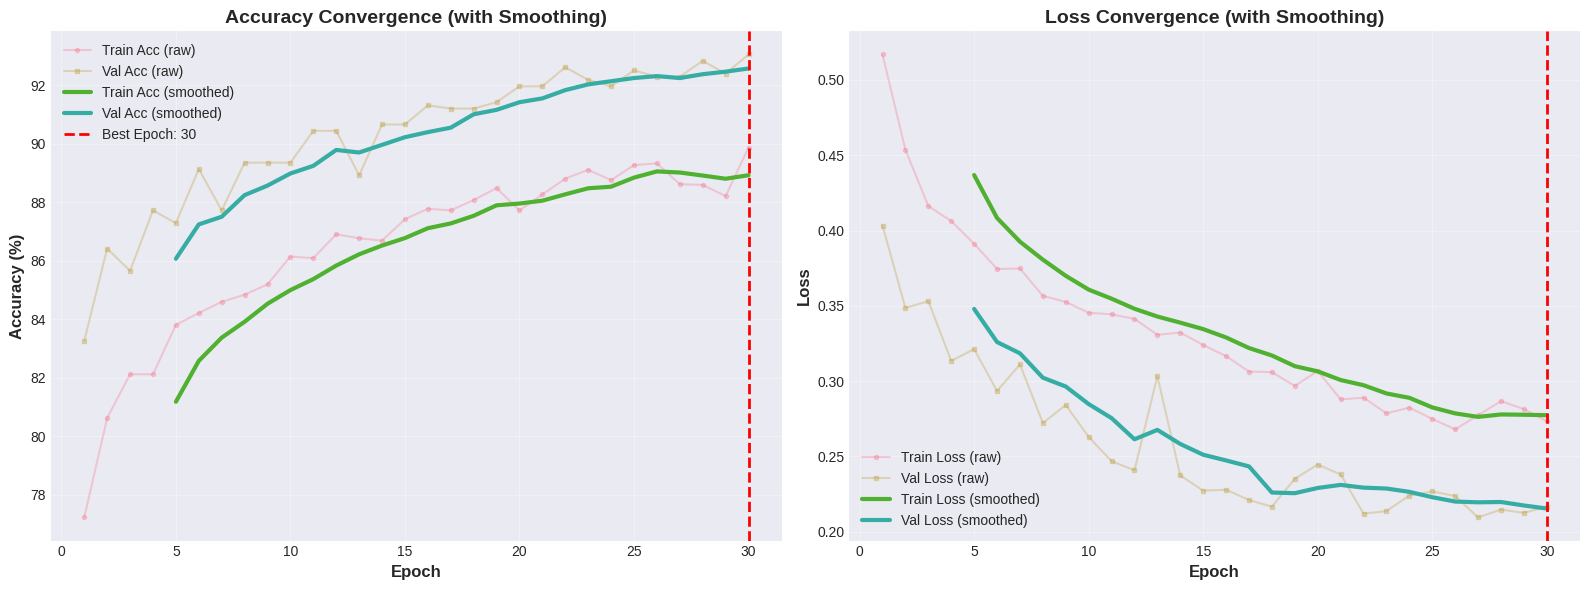


✓ Saved: convergence_analysis.png


FINAL TRAINING SUMMARY
Total Epochs Trained: 30
Best Epoch: 30
Best Validation Accuracy: 93.04%
Final Train Accuracy: 89.86%
Overfitting Gap at Best: -3.18%

Weighted F1-Score: 0.9305
Weighted Precision: 0.9315
Weighted Recall: 0.9304

Model Performance:
  ✓ Fall Detection Rate (Sensitivity): 94.72%
  ✓ No-Fall Detection Rate (Specificity): 91.65%
  ✓ False Positive Rate: 8.35%
  ✓ False Negative Rate: 5.28%

✓ All visualizations saved successfully!

Generated files:
  - training_curves.png
  - confusion_matrix_metrics.png
  - convergence_analysis.png


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score, 
    precision_score, 
    recall_score,
    roc_curve,
    auc
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==============================================================
# LOAD DATA
# ==============================================================

print("Loading training history and predictions...")

# Load history
with open('/kaggle/working/history.json', 'r') as f:
    history = json.load(f)

# Load predictions
pred_data = np.load('/kaggle/working/predictions.npz')
predictions = pred_data['predictions']
labels = pred_data['labels']

print(f"✓ Loaded {len(history['train_loss'])} epochs")
print(f"✓ Loaded {len(predictions)} predictions\n")

# ==============================================================
# FIGURE 1: TRAINING CURVES (LOSS & ACCURACY)
# ==============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training & Validation Loss
ax = axes[0, 0]
epochs = range(1, len(history['train_loss']) + 1)
ax.plot(epochs, history['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=4)
ax.plot(epochs, history['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Mark best epoch
best_epoch_idx = np.argmax(history['val_acc'])
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch: {best_epoch_idx+1}')
ax.legend(fontsize=11)

# 2. Training & Validation Accuracy
ax = axes[0, 1]
ax.plot(epochs, history['train_acc'], 'o-', label='Train Acc', linewidth=2, markersize=4)
ax.plot(epochs, history['val_acc'], 's-', label='Val Acc', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add best accuracy line
best_val_acc = max(history['val_acc'])
ax.axhline(y=best_val_acc, color='green', linestyle='--', alpha=0.5, 
           label=f'Best Val Acc: {best_val_acc:.2f}%')
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', alpha=0.5)
ax.legend(fontsize=11)

# 3. Overfitting Gap Over Time
ax = axes[1, 0]
overfitting_gap = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
ax.plot(epochs, overfitting_gap, 'o-', color='orangered', linewidth=2, markersize=4)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.axhline(y=5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='5% threshold')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Train Acc - Val Acc (%)', fontsize=12, fontweight='bold')
ax.set_title('Overfitting Gap (Train - Val Accuracy)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', alpha=0.5)

# 4. Learning Rate Schedule
ax = axes[1, 1]
ax.plot(epochs, history['learning_rates'], 'o-', color='purple', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: training_curves.png\n")

# ==============================================================
# FIGURE 2: CONFUSION MATRIX & METRICS
# ==============================================================

fig = plt.figure(figsize=(16, 6))

# Calculate metrics
cm = confusion_matrix(labels, predictions)
f1 = f1_score(labels, predictions, average='weighted')
precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')

# 1. Confusion Matrix (Raw counts)
ax1 = plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Fall', 'No Fall'], 
            yticklabels=['Fall', 'No Fall'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# 2. Confusion Matrix (Normalized)
ax2 = plt.subplot(1, 3, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=True,
            xticklabels=['Fall', 'No Fall'], 
            yticklabels=['Fall', 'No Fall'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

# 3. Performance Metrics Bar Chart
ax3 = plt.subplot(1, 3, 3)
metrics = {
    'Accuracy': best_val_acc,
    'Precision': precision * 100,
    'Recall': recall * 100,
    'F1-Score': f1 * 100
}
bars = ax3.bar(metrics.keys(), metrics.values(), color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
ax3.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax3.set_title('Performance Metrics', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: confusion_matrix_metrics.png\n")

# ==============================================================
# FIGURE 3: DETAILED CLASSIFICATION REPORT
# ==============================================================

print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(labels, predictions, 
                          target_names=['Fall', 'No Fall'],
                          digits=4))
print("="*60)

# Per-class metrics
tn, fp, fn, tp = cm.ravel()

print("\nPER-CLASS DETAILED METRICS:")
print("="*60)
print(f"Fall Detection:")
print(f"  True Positives:  {tp}")
print(f"  False Negatives: {fn}")
print(f"  Sensitivity (Recall): {tp/(tp+fn)*100:.2f}%")
print(f"  Precision: {tp/(tp+fp)*100:.2f}%")
print()
print(f"No Fall Detection:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  Specificity: {tn/(tn+fp)*100:.2f}%")
print(f"  Precision: {tn/(tn+fn)*100:.2f}%")
print("="*60)

# ==============================================================
# FIGURE 4: TRAINING SUMMARY
# ==============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Best Epoch Analysis
ax = axes[0]
window = 5  # Moving average window
train_smoothed = np.convolve(history['train_acc'], np.ones(window)/window, mode='valid')
val_smoothed = np.convolve(history['val_acc'], np.ones(window)/window, mode='valid')
epochs_smoothed = range(window, len(history['train_acc']) + 1)

ax.plot(epochs, history['train_acc'], 'o-', alpha=0.3, label='Train Acc (raw)', markersize=3)
ax.plot(epochs, history['val_acc'], 's-', alpha=0.3, label='Val Acc (raw)', markersize=3)
ax.plot(epochs_smoothed, train_smoothed, '-', linewidth=3, label='Train Acc (smoothed)')
ax.plot(epochs_smoothed, val_smoothed, '-', linewidth=3, label='Val Acc (smoothed)')
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', linewidth=2, 
          label=f'Best Epoch: {best_epoch_idx+1}')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Convergence (with Smoothing)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Loss Convergence
ax = axes[1]
train_loss_smoothed = np.convolve(history['train_loss'], np.ones(window)/window, mode='valid')
val_loss_smoothed = np.convolve(history['val_loss'], np.ones(window)/window, mode='valid')

ax.plot(epochs, history['train_loss'], 'o-', alpha=0.3, label='Train Loss (raw)', markersize=3)
ax.plot(epochs, history['val_loss'], 's-', alpha=0.3, label='Val Loss (raw)', markersize=3)
ax.plot(epochs_smoothed, train_loss_smoothed, '-', linewidth=3, label='Train Loss (smoothed)')
ax.plot(epochs_smoothed, val_loss_smoothed, '-', linewidth=3, label='Val Loss (smoothed)')
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Loss Convergence (with Smoothing)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: convergence_analysis.png\n")

# ==============================================================
# FINAL SUMMARY
# ==============================================================

print("\n" + "="*60)
print("FINAL TRAINING SUMMARY")
print("="*60)
print(f"Total Epochs Trained: {len(history['train_loss'])}")
print(f"Best Epoch: {best_epoch_idx + 1}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Train Accuracy: {history['train_acc'][best_epoch_idx]:.2f}%")
print(f"Overfitting Gap at Best: {history['train_acc'][best_epoch_idx] - best_val_acc:.2f}%")
print()
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print()
print("Model Performance:")
print(f"  ✓ Fall Detection Rate (Sensitivity): {tp/(tp+fn)*100:.2f}%")
print(f"  ✓ No-Fall Detection Rate (Specificity): {tn/(tn+fp)*100:.2f}%")
print(f"  ✓ False Positive Rate: {fp/(fp+tn)*100:.2f}%")
print(f"  ✓ False Negative Rate: {fn/(fn+tp)*100:.2f}%")
print("="*60)

print("\n✓ All visualizations saved successfully!")
print("\nGenerated files:")
print("  - training_curves.png")
print("  - confusion_matrix_metrics.png")
print("  - convergence_analysis.png")

In [13]:
from google.colab import files  # works in Kaggle too
files.download('/kaggle/working/best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import subprocess

In [10]:
def download_youtube_video(url, output_path="/kaggle/working/test_video.mp4"):
    """Download video from YouTube using yt-dlp"""
    
    print(f"📥 Downloading video from YouTube...")
    print(f"URL: {url}")
    
    # Install yt-dlp if not installed
    try:
        import yt_dlp
    except:
        print("Installing yt-dlp...")
        subprocess.run(['pip', 'install', 'yt-dlp'], check=True)
        import yt_dlp
    
    # Download options
    ydl_opts = {
        'format': 'best[ext=mp4]',
        'outtmpl': output_path,
        'quiet': False,
    }
    
    # Download the video
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    
    print(f"✓ Video downloaded to: {output_path}\n")
    return output_path

In [ ]:
import os
import cv2
import json
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# ==============================================================
# CONFIG
# ==============================================================

CONFIG = {
    "data_dir": "/kaggle/input/fall-dataset-pre/Preprocessed_Videos",
    "save_dir": "/kaggle/working",

    "sequence_length": 8,
    "resize": (96, 96),

    "batch_size": 16,
    "num_epochs": 50,
    "learning_rate": 3e-4,  # Lower learning rate
    "weight_decay": 5e-4,   # Strong L2 regularization

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 2,
    "pin_memory": True,
    
    # Early stopping
    "early_stopping_patience": 10,
}


# ==============================================================
# SIMPLE DATASET (NO AUGMENTATION)
# ==============================================================

class SimpleFlowDataset(Dataset):
    def __init__(self, data_dir, seq_len=8, resize=(96, 96)):
        self.seq_len = seq_len
        self.resize = resize
        self.samples = []

        for label_name, label in [("fall", 0), ("no_fall", 1)]:
            folder = os.path.join(data_dir, label_name, "optical_flow")
            if not os.path.exists(folder): 
                continue

            for f in os.listdir(folder):
                if f.endswith("_flow.npy"):
                    self.samples.append((os.path.join(folder, f), label))

        print("Total samples:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        flow = np.load(path)  # (T, H, W, 2)

        # Resize all frames
        frames = [cv2.resize(f, self.resize) for f in flow]

        # Sample frames uniformly
        idx = np.linspace(0, len(frames)-1, self.seq_len).astype(int)
        frames = np.array(frames)[idx]  # (seq, H, W, 2)

        # Convert to tensor (T, C, H, W)
        x = torch.tensor(frames).permute(0, 3, 1, 2).float()
        y = torch.tensor(label).long()
        return x, y


# ==============================================================
# IMPROVED 3D CNN WITH STRONG REGULARIZATION
# ==============================================================

class CNN3D_Flow(nn.Module):
    def __init__(self, dropout_rate=0.6):
        super().__init__()

        self.features = nn.Sequential(
            # Conv3D 1
            nn.Conv3d(2, 32, kernel_size=(3, 5, 5), padding=(1, 2, 2)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout3d(0.25),  # Dropout in conv layers
            nn.MaxPool3d(kernel_size=(1, 2, 2)),

            # Conv3D 2
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Dropout3d(0.3),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),

            # Conv3D 3
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Dropout3d(0.35),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
        )

        # Simplified classifier with strong dropout
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 12 * 12, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        # x: (B, T, 2, H, W) → convert to (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


# ==============================================================
# TRAIN + VALIDATION
# ==============================================================

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item()
        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()

    acc = 100 * correct / total
    return total_loss / len(loader), acc


def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Validation", leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            _, pred = out.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = 100 * correct / total
    return total_loss / len(loader), acc, all_preds, all_labels


# ==============================================================
# MAIN TRAINING SCRIPT
# ==============================================================

def main():
    device = CONFIG["device"]
    print("="*60)
    print("FALL DETECTION - REGULARIZATION-ONLY TRAINING")
    print("="*60)
    print(f"Device: {device}")
    print(f"Learning Rate: {CONFIG['learning_rate']}")
    print(f"Weight Decay: {CONFIG['weight_decay']}")
    print(f"Early Stopping Patience: {CONFIG['early_stopping_patience']}")
    print(f"NO DATA AUGMENTATION")
    print("="*60 + "\n")

    # Create dataset
    dataset = SimpleFlowDataset(
        CONFIG["data_dir"],
        seq_len=CONFIG["sequence_length"],
        resize=CONFIG["resize"]
    )

    # Split dataset with fixed seed
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    generator = torch.Generator().manual_seed(42)
    train_set, val_set = torch.utils.data.random_split(
        dataset, [train_size, val_size], generator=generator
    )

    print(f"Training samples: {len(train_set)}")
    print(f"Validation samples: {len(val_set)}\n")

    train_loader = DataLoader(
        train_set, batch_size=CONFIG["batch_size"],
        shuffle=True, num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"]
    )

    val_loader = DataLoader(
        val_set, batch_size=CONFIG["batch_size"],
        shuffle=False, num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"]
    )

    model = CNN3D_Flow(dropout_rate=0.6).to(device)
    print("Model parameters:", sum(p.numel() for p in model.parameters()))

    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"]
    )
    
    # Reduce LR on plateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )
    
    criterion = nn.CrossEntropyLoss()

    history = {
        "train_loss": [], "train_acc": [], 
        "val_loss": [], "val_acc": [],
        "learning_rates": []
    }
    
    best_acc = 0
    best_epoch = 0
    patience_counter = 0
    
    # Store best predictions for confusion matrix
    best_preds = None
    best_labels = None

    print("Starting training...\n")

    for epoch in range(1, CONFIG["num_epochs"] + 1):
        print(f"{'='*60}")
        print(f"EPOCH {epoch}/{CONFIG['num_epochs']}")
        print(f"{'='*60}")
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.6f}")

        # Train and validate
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        vl_loss, vl_acc, preds, labels = validate(model, val_loader, criterion, device)

        print(f"Train: Loss={tr_loss:.4f} | Acc={tr_acc:.2f}%")
        print(f"Val:   Loss={vl_loss:.4f} | Acc={vl_acc:.2f}%")
        
        gap = tr_acc - vl_acc
        print(f"Overfitting Gap: {gap:.2f}%")

        # Update scheduler based on validation accuracy
        scheduler.step(vl_acc)

        # Save history
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(vl_acc)
        history["learning_rates"].append(current_lr)

        # Save best model
        if vl_acc > best_acc:
            best_acc = vl_acc
            best_epoch = epoch
            patience_counter = 0
            best_preds = preds
            best_labels = labels
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'predictions': preds,
                'labels': labels
            }, os.path.join(CONFIG["save_dir"], "best_model.pth"))
            print(f"✓ NEW BEST MODEL! Val Acc: {best_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")

        # Early stopping
        if patience_counter >= CONFIG["early_stopping_patience"]:
            print(f"\n{'='*60}")
            print(f"Early stopping at epoch {epoch}")
            print(f"Best Val Acc: {best_acc:.2f}% at epoch {best_epoch}")
            print(f"{'='*60}")
            break

        print()

    # Save history and best predictions
    history['best_predictions'] = best_preds
    history['best_labels'] = best_labels
    history['best_epoch'] = best_epoch
    history['best_acc'] = best_acc
    
    with open(os.path.join(CONFIG["save_dir"], "history.json"), "w") as f:
        json.dump({k: v for k, v in history.items() if k not in ['best_predictions', 'best_labels']}, f, indent=2)
    
    # Save predictions separately
    np.savez(os.path.join(CONFIG["save_dir"], "predictions.npz"),
             predictions=best_preds,
             labels=best_labels)

    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)
    print(f"Best validation accuracy: {best_acc:.2f}% (epoch {best_epoch})")
    print(f"Final overfitting gap: {history['train_acc'][best_epoch-1] - best_acc:.2f}%")
    print("="*60)


if __name__ == "__main__":
    main()

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score, 
    precision_score, 
    recall_score,
    roc_curve,
    auc
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==============================================================
# LOAD DATA
# ==============================================================

print("Loading training history and predictions...")

# Load history
with open('/kaggle/working/history.json', 'r') as f:
    history = json.load(f)

# Load predictions
pred_data = np.load('/kaggle/working/predictions.npz')
predictions = pred_data['predictions']
labels = pred_data['labels']

print(f"✓ Loaded {len(history['train_loss'])} epochs")
print(f"✓ Loaded {len(predictions)} predictions\n")

# ==============================================================
# FIGURE 1: TRAINING CURVES (LOSS & ACCURACY)
# ==============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training & Validation Loss
ax = axes[0, 0]
epochs = range(1, len(history['train_loss']) + 1)
ax.plot(epochs, history['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=4)
ax.plot(epochs, history['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Mark best epoch
best_epoch_idx = np.argmax(history['val_acc'])
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch: {best_epoch_idx+1}')
ax.legend(fontsize=11)

# 2. Training & Validation Accuracy
ax = axes[0, 1]
ax.plot(epochs, history['train_acc'], 'o-', label='Train Acc', linewidth=2, markersize=4)
ax.plot(epochs, history['val_acc'], 's-', label='Val Acc', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add best accuracy line
best_val_acc = max(history['val_acc'])
ax.axhline(y=best_val_acc, color='green', linestyle='--', alpha=0.5, 
           label=f'Best Val Acc: {best_val_acc:.2f}%')
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', alpha=0.5)
ax.legend(fontsize=11)

# 3. Overfitting Gap Over Time
ax = axes[1, 0]
overfitting_gap = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
ax.plot(epochs, overfitting_gap, 'o-', color='orangered', linewidth=2, markersize=4)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.axhline(y=5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='5% threshold')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Train Acc - Val Acc (%)', fontsize=12, fontweight='bold')
ax.set_title('Overfitting Gap (Train - Val Accuracy)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', alpha=0.5)

# 4. Learning Rate Schedule
ax = axes[1, 1]
ax.plot(epochs, history['learning_rates'], 'o-', color='purple', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: training_curves.png\n")

# ==============================================================
# FIGURE 2: CONFUSION MATRIX & METRICS
# ==============================================================

fig = plt.figure(figsize=(16, 6))

# Calculate metrics
cm = confusion_matrix(labels, predictions)
f1 = f1_score(labels, predictions, average='weighted')
precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')

# 1. Confusion Matrix (Raw counts)
ax1 = plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Fall', 'No Fall'], 
            yticklabels=['Fall', 'No Fall'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# 2. Confusion Matrix (Normalized)
ax2 = plt.subplot(1, 3, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=True,
            xticklabels=['Fall', 'No Fall'], 
            yticklabels=['Fall', 'No Fall'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

# 3. Performance Metrics Bar Chart
ax3 = plt.subplot(1, 3, 3)
metrics = {
    'Accuracy': best_val_acc,
    'Precision': precision * 100,
    'Recall': recall * 100,
    'F1-Score': f1 * 100
}
bars = ax3.bar(metrics.keys(), metrics.values(), color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
ax3.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax3.set_title('Performance Metrics', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: confusion_matrix_metrics.png\n")

# ==============================================================
# FIGURE 3: DETAILED CLASSIFICATION REPORT
# ==============================================================

print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(labels, predictions, 
                          target_names=['Fall', 'No Fall'],
                          digits=4))
print("="*60)

# Per-class metrics
tn, fp, fn, tp = cm.ravel()

print("\nPER-CLASS DETAILED METRICS:")
print("="*60)
print(f"Fall Detection:")
print(f"  True Positives:  {tp}")
print(f"  False Negatives: {fn}")
print(f"  Sensitivity (Recall): {tp/(tp+fn)*100:.2f}%")
print(f"  Precision: {tp/(tp+fp)*100:.2f}%")
print()
print(f"No Fall Detection:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  Specificity: {tn/(tn+fp)*100:.2f}%")
print(f"  Precision: {tn/(tn+fn)*100:.2f}%")
print("="*60)

# ==============================================================
# FIGURE 4: TRAINING SUMMARY
# ==============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Best Epoch Analysis
ax = axes[0]
window = 5  # Moving average window
train_smoothed = np.convolve(history['train_acc'], np.ones(window)/window, mode='valid')
val_smoothed = np.convolve(history['val_acc'], np.ones(window)/window, mode='valid')
epochs_smoothed = range(window, len(history['train_acc']) + 1)

ax.plot(epochs, history['train_acc'], 'o-', alpha=0.3, label='Train Acc (raw)', markersize=3)
ax.plot(epochs, history['val_acc'], 's-', alpha=0.3, label='Val Acc (raw)', markersize=3)
ax.plot(epochs_smoothed, train_smoothed, '-', linewidth=3, label='Train Acc (smoothed)')
ax.plot(epochs_smoothed, val_smoothed, '-', linewidth=3, label='Val Acc (smoothed)')
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', linewidth=2, 
          label=f'Best Epoch: {best_epoch_idx+1}')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Convergence (with Smoothing)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Loss Convergence
ax = axes[1]
train_loss_smoothed = np.convolve(history['train_loss'], np.ones(window)/window, mode='valid')
val_loss_smoothed = np.convolve(history['val_loss'], np.ones(window)/window, mode='valid')

ax.plot(epochs, history['train_loss'], 'o-', alpha=0.3, label='Train Loss (raw)', markersize=3)
ax.plot(epochs, history['val_loss'], 's-', alpha=0.3, label='Val Loss (raw)', markersize=3)
ax.plot(epochs_smoothed, train_loss_smoothed, '-', linewidth=3, label='Train Loss (smoothed)')
ax.plot(epochs_smoothed, val_loss_smoothed, '-', linewidth=3, label='Val Loss (smoothed)')
ax.axvline(x=best_epoch_idx+1, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Loss Convergence (with Smoothing)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: convergence_analysis.png\n")

# ==============================================================
# FINAL SUMMARY
# ==============================================================

print("\n" + "="*60)
print("FINAL TRAINING SUMMARY")
print("="*60)
print(f"Total Epochs Trained: {len(history['train_loss'])}")
print(f"Best Epoch: {best_epoch_idx + 1}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Train Accuracy: {history['train_acc'][best_epoch_idx]:.2f}%")
print(f"Overfitting Gap at Best: {history['train_acc'][best_epoch_idx] - best_val_acc:.2f}%")
print()
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print()
print("Model Performance:")
print(f"  ✓ Fall Detection Rate (Sensitivity): {tp/(tp+fn)*100:.2f}%")
print(f"  ✓ No-Fall Detection Rate (Specificity): {tn/(tn+fp)*100:.2f}%")
print(f"  ✓ False Positive Rate: {fp/(fp+tn)*100:.2f}%")
print(f"  ✓ False Negative Rate: {fn/(fn+tp)*100:.2f}%")
print("="*60)

print("\n✓ All visualizations saved successfully!")
print("\nGenerated files:")
print("  - training_curves.png")
print("  - confusion_matrix_metrics.png")
print("  - convergence_analysis.png")

In [8]:
import os
import cv2
import json
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# ==============================================================
# CONFIG
# ==============================================================

CONFIG = {
    "data_dir": "/kaggle/input/full-data-fall/Preprocessed_Videos",
    "save_dir": "/kaggle/working",

    "sequence_length": 10,
    "resize": (96, 96),

    "batch_size": 16,
    "num_epochs": 30,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 2,
    "pin_memory": True,
}


# ==============================================================
# DATASET
# ==============================================================

class SimpleFlowDataset(Dataset):
    def __init__(self, data_dir, seq_len=10, resize=(96, 96)):
        self.seq_len = seq_len
        self.resize = resize
        self.samples = []

        for label_name, label in [("fall", 0), ("no_fall", 1)]:
            folder = os.path.join(data_dir, label_name, "optical_flow")
            if not os.path.exists(folder): 
                continue

            for f in os.listdir(folder):
                if f.endswith("_flow.npy"):
                    self.samples.append((os.path.join(folder, f), label))

        print("Total samples:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        flow = np.load(path)  # (T, H, W, 2)

        # Resize
        frames = [cv2.resize(f, self.resize) for f in flow]

        # Sample frames
        idx = np.linspace(0, len(frames)-1, self.seq_len).astype(int)
        frames = np.array(frames)[idx]

        # Flatten each frame: (seq, H*W*2)
        frames_flat = frames.reshape(self.seq_len, -1)

        x = torch.tensor(frames_flat).float()
        y = torch.tensor(label).long()
        return x, y


# ==============================================================
# SIMPLE LSTM MODEL
# ==============================================================

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        
        # Take last timestep
        last_output = lstm_out[:, -1, :]
        
        return self.classifier(last_output)


# ==============================================================
# TRAIN + VALIDATION
# ==============================================================

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()

    acc = 100 * correct / total
    return total_loss / len(loader), acc


def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Validation", leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            _, pred = out.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = 100 * correct / total
    return total_loss / len(loader), acc, all_preds, all_labels


# ==============================================================
# MAIN
# ==============================================================

def main():
    device = CONFIG["device"]
    print("="*60)
    print("SIMPLE LSTM FALL DETECTION")
    print("="*60)
    print(f"Device: {device}\n")

    # Dataset
    dataset = SimpleFlowDataset(
        CONFIG["data_dir"],
        seq_len=CONFIG["sequence_length"],
        resize=CONFIG["resize"]
    )

    if len(dataset) == 0:
        print("❌ No samples found!")
        return

    # Split
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    generator = torch.Generator().manual_seed(42)
    train_set, val_set = torch.utils.data.random_split(
        dataset, [train_size, val_size], generator=generator
    )

    print(f"Training: {len(train_set)}, Validation: {len(val_set)}\n")

    train_loader = DataLoader(
        train_set, batch_size=CONFIG["batch_size"],
        shuffle=True, num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"]
    )

    val_loader = DataLoader(
        val_set, batch_size=CONFIG["batch_size"],
        shuffle=False, num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"]
    )

    # Model
    input_size = CONFIG["resize"][0] * CONFIG["resize"][1] * 2  # H*W*2
    model = SimpleLSTM(input_size, hidden_size=128).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}\n")

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"]
    )
    
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_acc = 0
    best_preds = None
    best_labels = None

    print("Training...\n")

    for epoch in range(1, CONFIG["num_epochs"] + 1):
        print(f"Epoch {epoch}/{CONFIG['num_epochs']}")

        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        vl_loss, vl_acc, preds, labels = validate(model, val_loader, criterion, device)

        print(f"  Train: Loss={tr_loss:.4f}, Acc={tr_acc:.2f}%")
        print(f"  Val:   Loss={vl_loss:.4f}, Acc={vl_acc:.2f}%")
        print(f"  Gap: {tr_acc - vl_acc:.2f}%\n")

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(vl_acc)

        if vl_acc > best_acc:
            best_acc = vl_acc
            best_preds = preds
            best_labels = labels
            torch.save(model.state_dict(), 
                      os.path.join(CONFIG["save_dir"], "best_model_simple_lstm.pth"))
            print(f"  ✓ New best: {best_acc:.2f}%\n")

    # Save
    with open(os.path.join(CONFIG["save_dir"], "history_simple_lstm.json"), "w") as f:
        json.dump(history, f, indent=2)
    
    np.savez(os.path.join(CONFIG["save_dir"], "predictions_simple_lstm.npz"),
             predictions=best_preds, labels=best_labels)

    print("="*60)
    print(f"DONE! Best accuracy: {best_acc:.2f}%")
    print("="*60)


if __name__ == "__main__":
    main()

SIMPLE LSTM FALL DETECTION
Device: cuda

Total samples: 4600
Training: 3680, Validation: 920

Model parameters: 9,644,226

Training...

Epoch 1/30


  Train: Loss=0.4338, Acc=80.84%
  Val:   Loss=0.3756, Acc=82.50%
  Gap: -1.66%

  ✓ New best: 82.50%

Epoch 2/30


  Train: Loss=0.2221, Acc=92.28%
  Val:   Loss=0.4409, Acc=83.15%
  Gap: 9.13%

  ✓ New best: 83.15%

Epoch 3/30


  Train: Loss=0.1277, Acc=95.92%
  Val:   Loss=0.4861, Acc=84.13%
  Gap: 11.79%

  ✓ New best: 84.13%

Epoch 4/30


  Train: Loss=0.0826, Acc=97.61%
  Val:   Loss=0.4972, Acc=84.24%
  Gap: 13.37%

  ✓ New best: 84.24%

Epoch 5/30


  Train: Loss=0.0737, Acc=97.64%
  Val:   Loss=0.5433, Acc=84.67%
  Gap: 12.96%

  ✓ New best: 84.67%

Epoch 6/30


  Train: Loss=0.0700, Acc=97.91%
  Val:   Loss=0.5472, Acc=84.57%
  Gap: 13.34%

Epoch 7/30


  Train: Loss=0.0682, Acc=97.77%
  Val:   Loss=0.5061, Acc=86.63%
  Gap: 11.14%

  ✓ New best: 86.63%

Epoch 8/30


  Train: Loss=0.0541, Acc=98.56%
  Val:   Loss=0.5206, Acc=83.91%
  Gap: 14.65%

Epoch 9/30


  Train: Loss=0.0632, Acc=97.91%
  Val:   Loss=0.6063, Acc=85.00%
  Gap: 12.91%

Epoch 10/30


  Train: Loss=0.0624, Acc=97.99%
  Val:   Loss=0.5841, Acc=82.28%
  Gap: 15.71%

Epoch 11/30


  Train: Loss=0.0426, Acc=98.64%
  Val:   Loss=0.5941, Acc=83.15%
  Gap: 15.49%

Epoch 12/30


  Train: Loss=0.0566, Acc=98.02%
  Val:   Loss=0.5442, Acc=83.59%
  Gap: 14.43%

Epoch 13/30


  Train: Loss=0.0654, Acc=98.04%
  Val:   Loss=0.5442, Acc=84.57%
  Gap: 13.48%

Epoch 14/30


  Train: Loss=0.0565, Acc=98.32%
  Val:   Loss=0.6319, Acc=84.24%
  Gap: 14.08%

Epoch 15/30


  Train: Loss=0.0570, Acc=98.10%
  Val:   Loss=0.5541, Acc=83.48%
  Gap: 14.62%

Epoch 16/30


  Train: Loss=0.0426, Acc=98.78%
  Val:   Loss=0.6199, Acc=84.02%
  Gap: 14.76%

Epoch 17/30


  Train: Loss=0.0434, Acc=98.72%
  Val:   Loss=0.5315, Acc=83.15%
  Gap: 15.57%

Epoch 18/30


  Train: Loss=0.0486, Acc=98.53%
  Val:   Loss=0.7071, Acc=85.22%
  Gap: 13.32%

Epoch 19/30


  Train: Loss=0.0574, Acc=98.02%
  Val:   Loss=0.7086, Acc=82.07%
  Gap: 15.95%

Epoch 20/30


  Train: Loss=0.0684, Acc=97.96%
  Val:   Loss=0.6079, Acc=82.50%
  Gap: 15.46%

Epoch 21/30


  Train: Loss=0.0539, Acc=98.29%
  Val:   Loss=0.7303, Acc=84.35%
  Gap: 13.94%

Epoch 22/30


  Train: Loss=0.0396, Acc=98.89%
  Val:   Loss=0.6571, Acc=83.04%
  Gap: 15.84%

Epoch 23/30


  Train: Loss=0.0351, Acc=99.08%
  Val:   Loss=0.6604, Acc=83.48%
  Gap: 15.60%

Epoch 24/30


  Train: Loss=0.0244, Acc=99.18%
  Val:   Loss=0.7280, Acc=84.57%
  Gap: 14.62%

Epoch 25/30


  Train: Loss=0.0371, Acc=98.80%
  Val:   Loss=0.6373, Acc=83.15%
  Gap: 15.65%

Epoch 26/30


  Train: Loss=0.0383, Acc=98.97%
  Val:   Loss=0.6751, Acc=85.43%
  Gap: 13.53%

Epoch 27/30


  Train: Loss=0.0514, Acc=98.10%
  Val:   Loss=0.6609, Acc=83.26%
  Gap: 14.84%

Epoch 28/30


  Train: Loss=0.0627, Acc=98.02%
  Val:   Loss=0.5529, Acc=84.67%
  Gap: 13.34%

Epoch 29/30


  Train: Loss=0.0504, Acc=98.42%
  Val:   Loss=0.7007, Acc=83.91%
  Gap: 14.51%

Epoch 30/30


  Train: Loss=0.0525, Acc=98.45%
  Val:   Loss=0.6487, Acc=83.15%
  Gap: 15.30%

DONE! Best accuracy: 86.63%


Loaded 30 epochs



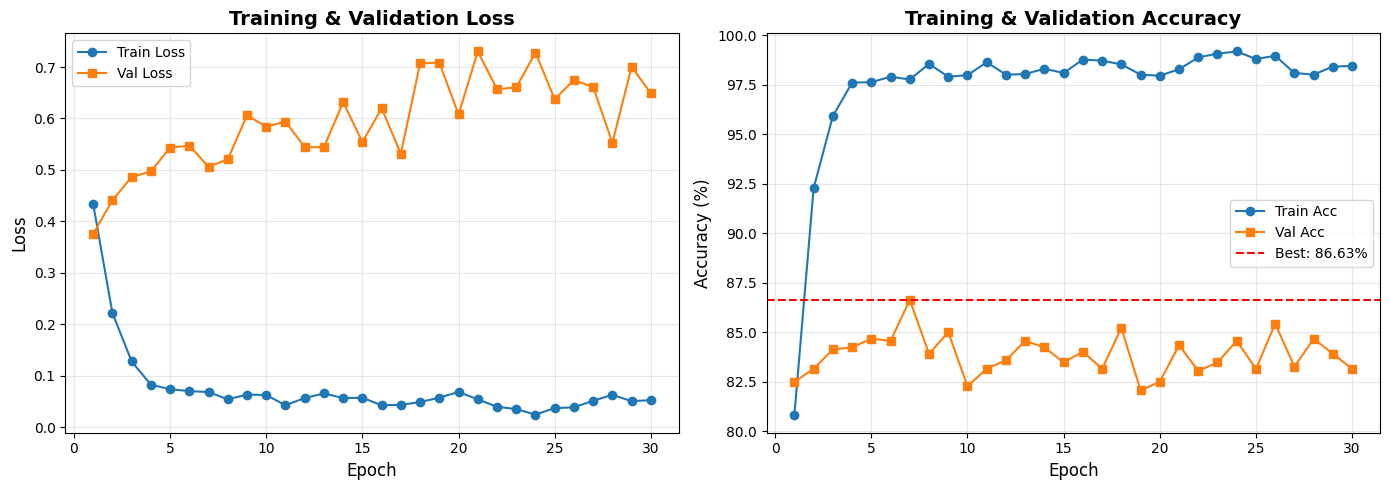

✓ Saved curves



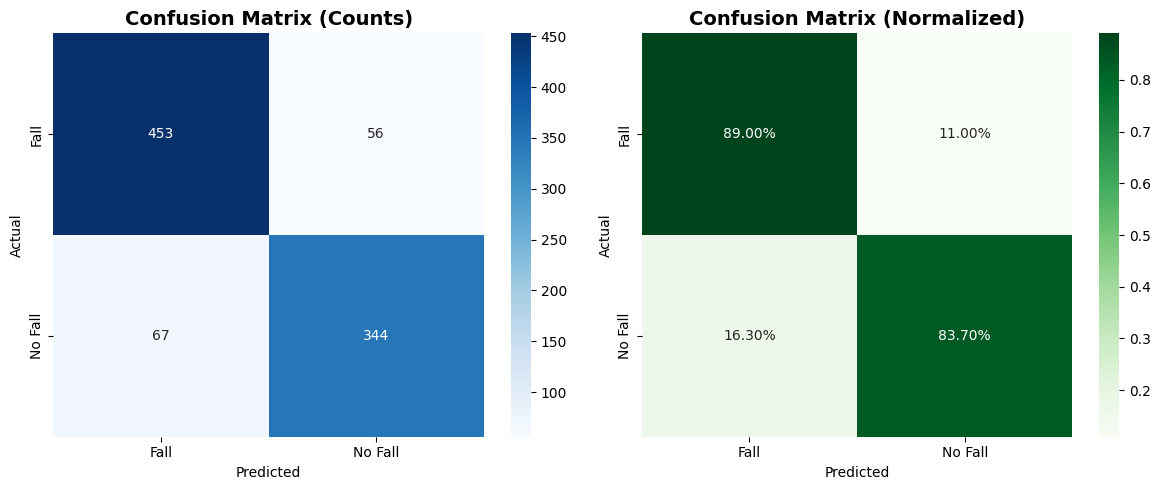

✓ Saved confusion matrix

RESULTS
              precision    recall  f1-score   support

        Fall     0.8712    0.8900    0.8805       509
     No Fall     0.8600    0.8370    0.8483       411

    accuracy                         0.8663       920
   macro avg     0.8656    0.8635    0.8644       920
weighted avg     0.8662    0.8663    0.8661       920


Best Validation Accuracy: 86.63%
F1-Score: 0.8661

Fall Detection: 83.70%
No-Fall Detection: 89.00%
False Alarms: 11.00%


In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Load data
with open('/kaggle/working/history_simple_lstm.json', 'r') as f:
    history = json.load(f)

pred_data = np.load('/kaggle/working/predictions_simple_lstm.npz')
predictions = pred_data['predictions']
labels = pred_data['labels']

print(f"Loaded {len(history['train_loss'])} epochs\n")

# ==============================================================
# PLOT 1: Training Curves
# ==============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss')
axes[0].plot(epochs, history['val_loss'], 's-', label='Val Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'o-', label='Train Acc')
axes[1].plot(epochs, history['val_acc'], 's-', label='Val Acc')
best_val_acc = max(history['val_acc'])
axes[1].axhline(y=best_val_acc, color='red', linestyle='--', 
                label=f'Best: {best_val_acc:.2f}%')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/curves_simple_lstm.png', dpi=300)
plt.show()

print("✓ Saved curves\n")

# ==============================================================
# PLOT 2: Confusion Matrix
# ==============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(labels, predictions)

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Fall', 'No Fall'], 
            yticklabels=['Fall', 'No Fall'])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Fall', 'No Fall'], 
            yticklabels=['Fall', 'No Fall'])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_simple_lstm.png', dpi=300)
plt.show()

print("✓ Saved confusion matrix\n")

# ==============================================================
# METRICS
# ==============================================================

print("="*60)
print("RESULTS")
print("="*60)
print(classification_report(labels, predictions, 
                          target_names=['Fall', 'No Fall'], digits=4))

f1 = f1_score(labels, predictions, average='weighted')
tn, fp, fn, tp = cm.ravel()

print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
print(f"F1-Score: {f1:.4f}")
print(f"\nFall Detection: {tp/(tp+fn)*100:.2f}%")
print(f"No-Fall Detection: {tn/(tn+fp)*100:.2f}%")
print(f"False Alarms: {fp/(fp+tn)*100:.2f}%")
print("="*60)